In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
df = pd.read_csv("fatal-police-shootings-data.csv")

Kollar igenom datan för NaN values

In [2]:
df.isna().sum()

id                           0
name                         0
date                         0
manner_of_death              0
armed                      227
age                        235
gender                       2
race                       521
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       249
body_camera                  0
dtype: int64

Lägger till mapping för vad som är Deadly och inte Deadly

In [3]:

weapon_mapping = {
    # Deadly weapons (0)
    'gun': 0, 'pellet gun': 0, 'BB gun': 0, 'Airsoft pistol': 0,
    'guns and explosives': 0, 'gun and knife': 0, 'gun and car': 0,
    'grenade': 0, 'incendiary device': 0, 'samurai sword': 0,
    'machete': 0, 'sword': 0, 'hatchet': 0, 'knife': 0,
    'bayonet': 0, 'crossbow': 0, 'vehicle': 0, 'gun and vehicle': 0,
    'machete and gun': 0, 'nail gun': 0, 'shovel': 0, 'hammer': 0,
    'metal object': 0, 'screwdriver': 0, 'metal pole': 0, 'Taser': 0,
    'metal pipe': 0, 'blunt object': 0, 'sharp object': 0,
    'meat cleaver': 0, 'carjack': 0, 'chain': 0, 'brick': 0,
    'baseball bat': 0, 'lawn mower blade': 0, 'flagpole': 0,
    'scissors': 0, 'crowbar': 0, 'tire iron': 0, 'chainsaw': 0,
    'wrench': 0, 'piece of wood': 0, 'pipe': 0, 'glass shard': 0,
    'pepper spray': 0, 'oar': 0, 'fireworks': 0, 'ice pick': 0,
    'car, knife and mace': 0, 'straight edge razor': 0,

    # Not deadly (1)
    'unarmed': 1, 'toy weapon': 1, 'bean-bag gun': 1, 'stapler': 1,
    'pen': 1, 'claimed to be armed': 1, 'beer bottle': 1,
    'walking stick': 1, 'air pistol': 1, 'flashlight': 1,
    'unknown weapon': 1, 'undetermined': 1, pd.NA: 1, 'nan': 1,
}

df['armed'] = df['armed'].map(weapon_mapping).fillna(1)

Ändrar om values till nummer

In [4]:
df["age"] = df["age"].fillna(df["age"].median())
df["gender"] = df["gender"].map({"M": 0, "F": 1}).fillna(0)
df["body_camera"] = df["body_camera"].map({True: 1, False: 0}).fillna(0)
df["signs_of_mental_illness"] = df["signs_of_mental_illness"].map({True: 1, False: 0}).fillna(0)
df["threat_level"] = df["threat_level"].map({"attack": 0, "other": 1, "undetermined": 1}).fillna(1)
df["race"] = df["race"].map({"W": 0, "B": 1, "A": 2, "H": 3, "O": 4, "N": 5}).fillna(5)
df["flee"] = df["flee"].map({"Car": 0, "Foot": 0, "Other": 1, "Not fleeing": 1}).fillna(1)
df['armed'] = df['armed'].map(weapon_mapping).fillna(1) 
df["manner_of_death"] = df["manner_of_death"].map({"shot": 0, "shot and Tasered": 1}).fillna(0)
df.isna().sum()

id                         0
name                       0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
dtype: int64

In [5]:
df["body_camera"].value_counts()

body_camera
0    4798
1     618
Name: count, dtype: int64

Tränar modellen genom att se om body camera va på eller inte på under händelsen

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df[["age", "gender", "body_camera", "signs_of_mental_illness", "race", "armed", "flee", "manner_of_death", "threat_level"]]
y = df["body_camera"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Testar modellens resultat

In [7]:

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the XGBoost model
model = XGBClassifier(eval_metric='mlogloss', scale_pos_weight=1)  # Example weight
model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[952   0]
 [  0 132]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       952
           1       1.00      1.00      1.00       132

    accuracy                           1.00      1084
   macro avg       1.00      1.00      1.00      1084
weighted avg       1.00      1.00      1.00      1084


Accuracy:
1.0


Kör en gridsearch för kolla om det var overfitting

In [8]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline


imbalance_ratio = len(df[df['body_camera'] == 0]) / len(df[df['body_camera'] == 1])

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('smote', SMOTEENN()), 
    ('xgb', XGBClassifier(eval_metric='mlogloss'))
])

# Define your parameter grid
param_grid = {
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': [3, 5],
    'xgb__n_estimators': [200, 300],
    'xgb__min_child_weight': [1, 5],
    'xgb__gamma': [0, 0.1],
    'xgb__subsample': [0.7, 0.8],
    'xgb__colsample_bytree': [0.7, 0.8],
    'xgb__scale_pos_weight': [imbalance_ratio] 
}


grid_search = GridSearchCV(pipeline, param_grid, scoring='balanced_accuracy', cv=5, n_jobs=-1)


grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


y_pred = grid_search.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Best Parameters: {'xgb__colsample_bytree': 0.7, 'xgb__gamma': 0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 200, 'xgb__scale_pos_weight': 7.763754045307444, 'xgb__subsample': 0.7}
Best F1 Score: 1.0
[[952   0]
 [  0 132]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       952
           1       1.00      1.00      1.00       132

    accuracy                           1.00      1084
   macro avg       1.00      1.00      1.00      1084
weighted avg       1.00      1.00      1.00      1084

Accuracy: 1.0


Här ser vi vilka features som var det viktigaste i modellens resultat
Under modellens beslutsfattande process användes f4 ofta, vilket tyder på att den har en stark påverkan på förutsägelserna
Funktioner f2 och f0: Dessa funktioner var också mycket viktiga, med poäng på 140 respektive 123. De användes ofta och hade därför ett betydande inflytande på modellens resultat.
Mindre viktiga funktioner: Funktioner som f7, f1 och f8 användes mycket mindre ofta, vilket tyder på att de hade en mindre påverkan på modellens förutsägelser.

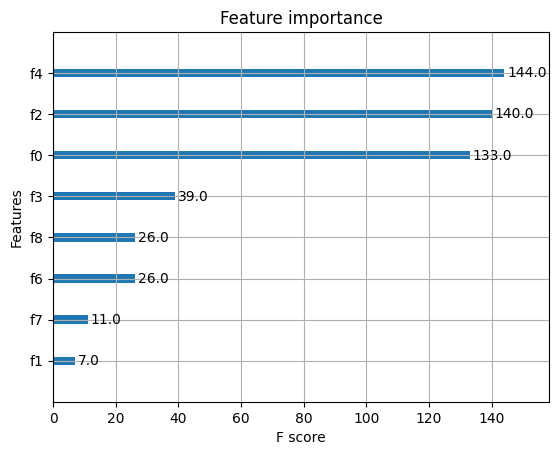

In [9]:

xgb_model = grid_search.best_estimator_.named_steps['xgb']
xgb.plot_importance(xgb_model)
plt.show()


Ändrar X till feature 0, 2 och 4 sen kör modellen samt visar resultaten igen och det ser ut som att den har 100% ifrån det vi ville uppnå

In [10]:

X = df[["age", "body_camera", "race"]]  # f0, f2, f4
y = df["body_camera"]

from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = XGBClassifier(eval_metric='mlogloss')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


[[952   0]
 [  0 132]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       952
           1       1.00      1.00      1.00       132

    accuracy                           1.00      1084
   macro avg       1.00      1.00      1.00      1084
weighted avg       1.00      1.00      1.00      1084

Accuracy: 1.0
